# Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)

import sys
sys.path.insert(0, "../02_src")

In [2]:
merged_df = pd.read_csv("../00_data/1_interim/merged_data.csv")

### Handle High Missing Values #1: by Code (Country ID)

In [3]:
# Missing Values by Country ID (Code)
all_missing_values = merged_df.isnull().groupby(merged_df["Entity"]).sum()
# 9 main potential features: 
values_count_per_country = merged_df.groupby(merged_df["Entity"]).size().iloc[0] * 9

all_missing_values["total_missing"] = all_missing_values.sum(axis=1)
all_missing_values["total_missing_%"] = round( ( all_missing_values["total_missing"] / values_count_per_country ) * 100, 2)
#plot top 12 countries with most missing values
top_missing_countries = all_missing_values.sort_values(ascending=False, by="total_missing")
top_12_missing = top_missing_countries["total_missing"].head(12)
print(f"Top 12 Countries with most missing values:\n{top_12_missing}")
#Threshold 50%: all countries with missing values over 50% get excluded from Dataframe
# 9 x 6 = 54 data point for each country --> 27 NaNs as upper limit: 
# AIA       49 (Anguilla)
# MSR       48 (Montserrat)
# OWID_KOS  48 (Kosovo)
# COK       42 (Cook Islands)
# NIU       42 (Niue)
# TCA       39 (Turks and Caicos Islands)
# VGB       38 (British Virgin Islands)

Top 12 Countries with most missing values:
Entity
Anguilla                    49
Montserrat                  48
Kosovo                      48
Niue                        42
Cook Islands                42
Turks and Caicos Islands    39
British Virgin Islands      38
North Korea                 26
South Sudan                 26
Monaco                      25
Equatorial Guinea           22
Venezuela                   21
Name: total_missing, dtype: int64


In [4]:
# Exclude high missing values countries (threshold >= 50%) & save as new df
# new filtered version has now 967 missing values (306 less than before)
exclude_countries = top_missing_countries[top_missing_countries["total_missing_%"] >= 50]
filtered_df = merged_df[~merged_df["Entity"].isin(exclude_countries.index.tolist())].copy()
filtered_df.to_csv('../00_data/1_interim/filtered_data_01.csv', index=False)
filtered_df.isna().sum().sum()

967

In [5]:
filtered_df.isna().sum()

Code                                          0
Year                                          0
Entity                                        0
child_mortality_igme                          0
annual_healthcare_expenditure_per_capita     16
gdp_per_capita_worldbank                     42
nurses_and_midwives_per_1000_people         300
physicians_per_1000_people                  405
prevalence_of_undernourishment              156
share_of_population_urban                     0
share_without_improved_water                 16
vaccination_coverage_who_unicef               6
years_of_schooling                           26
dtype: int64

### Testing: Missing Indikators

In [8]:
# add _missing indikator: 0 if not missing, 1 if missing

example_train_set = pd.read_csv('../00_data/2_split/train_df_raw.csv', index_col=0)
missing_indicators_df = example_train_set.copy()

for column in missing_indicators_df.columns:
    if missing_indicators_df[column].isna().sum() > 0:
        missing_indicators_df[column+"_missing"] = missing_indicators_df[column].isna().astype(int)

In [9]:
missing_indicators_df.head()

,Code,Year,Entity,child_mortality_igme,annual_healthcare_expenditure_per_capita,gdp_per_capita_worldbank,nurses_and_midwives_per_1000_people,physicians_per_1000_people,prevalence_of_undernourishment,share_of_population_urban,...,vaccination_coverage_who_unicef,years_of_schooling,annual_healthcare_expenditure_per_capita_missing,gdp_per_capita_worldbank_missing,nurses_and_midwives_per_1000_people_missing,physicians_per_1000_people_missing,prevalence_of_undernourishment_missing,share_without_improved_water_missing,vaccination_coverage_who_unicef_missing,years_of_schooling_missing
0,AFG,2013,Afghanistan,78.022990,177.62009,3046.5798,0.255,0.291,19.4,24.373,...,64.0,0.672197,0,0,0,0,0,0,0,0
1,AFG,2014,Afghanistan,75.123625,201.79086,3017.9426,0.151,0.304,19.3,24.587,...,62.0,0.710609,0,0,0,0,0,0,0,0
2,AFG,2015,Afghanistan,72.438707,215.22618,2967.6921,0.133,0.291,20.0,24.803,...,64.0,0.749020,0,0,0,0,0,0,0,0
3,AFG,2016,Afghanistan,69.970040,238.74481,2958.7854,0.151,0.284,20.5,25.020,...,66.0,1.009183,0,0,0,0,0,0,0,0
4,AFG,2017,Afghanistan,67.637370,264.20660,2952.9990,0.179,0.245,21.4,25.250,...,64.0,1.269347,0,0,0,0,0,0,0,0


### Test Imputation (for whole df)

In [10]:
df_for_imp = pd.read_csv("../00_data/1_interim/mar_test_data.csv")
df_for_imp

wb_regions = pd.get_dummies(df_for_imp["World regions according to WB"], dtype="int64") #create dummies from WB regions
df_imp_test = pd.concat([df_for_imp, wb_regions], axis=1).drop(columns=["World regions according to WB"])

df_imp_test_full = pd.concat([df_for_imp, wb_regions], axis=1)

#df_imp_test = df_imp_test.drop(columns=["Year", "Entity", "child_mortality_igme"], axis=1)
df_imp_test = df_imp_test.drop(columns=["Code", "Year", "Entity", "child_mortality_igme"], axis=1)

In [11]:
# Calculate metrics of new imputed dfs for comparison
def calculate_metrics(original_df, imputed_df, cols):
    # Varianz
    variance_diff = ((imputed_df[cols].var() - original_df[cols].var()) / original_df[cols].var()) * 100
  
    print (f"Variance Differences in %:\n{round(variance_diff, 2)}")

#### Test 1: descriptive Imputation - Mean, Median

In [13]:
import data_exploration #visualizations

def nan_indicators(df):
    missing_indicators = df.columns.str.contains("_missing", regex=False)
    return missing_indicators

def wb_regions(df):
    regions = df.columns.str.contains("WB", regex=False)
    return regions

cols_with_nans = df_for_imp.columns[df_for_imp.isna().any()].tolist()
most_critical_cols = ["physicians_per_1000_people", "nurses_and_midwives_per_1000_people", "prevalence_of_undernourishment"]
label_col = df_for_imp[["child_mortality_igme"]]
country_col = df_for_imp[["Entity"]]

##### Mean

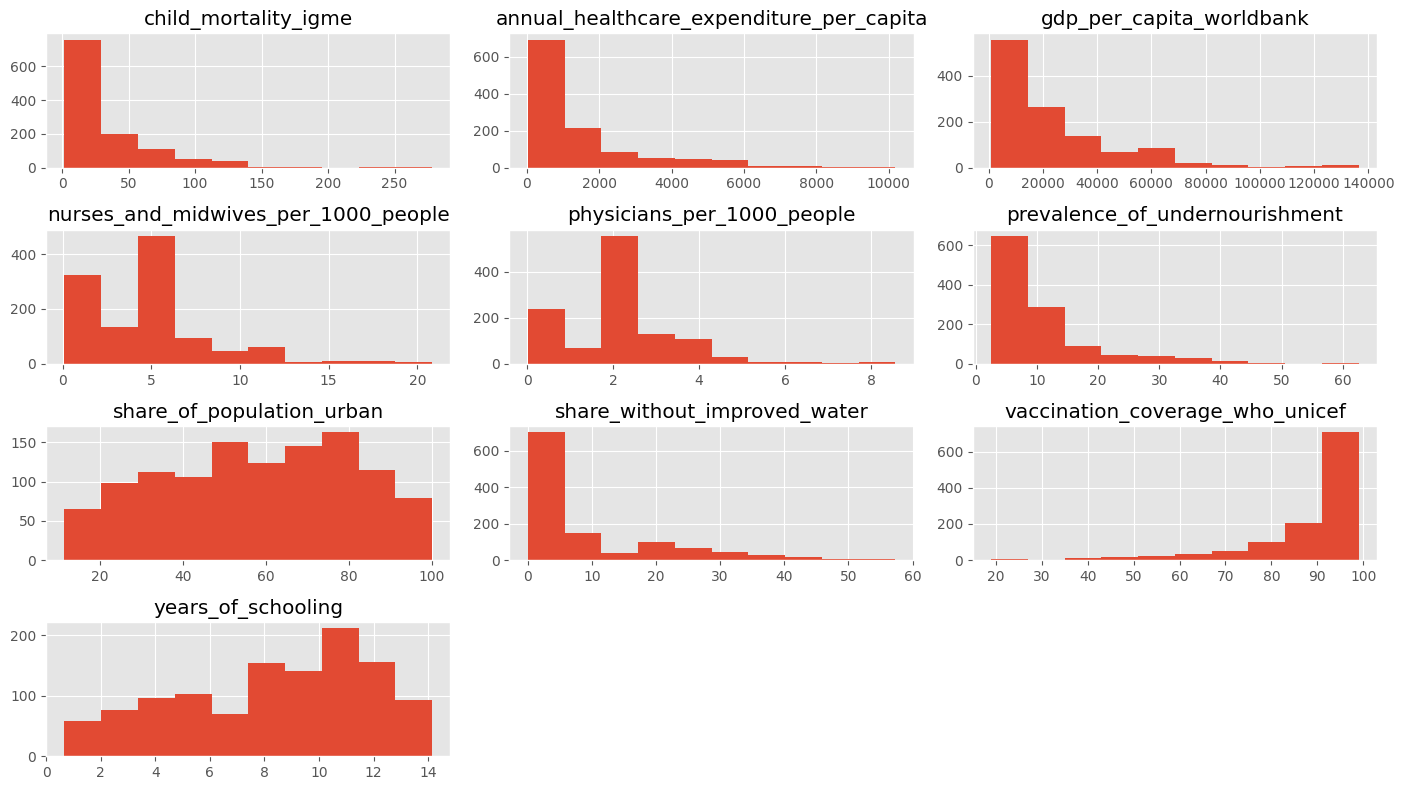

Variance Differences in %:
annual_healthcare_expenditure_per_capita    -1.38
gdp_per_capita_worldbank                    -3.63
nurses_and_midwives_per_1000_people        -25.93
physicians_per_1000_people                 -35.00
prevalence_of_undernourishment             -13.48
share_without_improved_water                -1.38
vaccination_coverage_who_unicef             -0.52
years_of_schooling                          -2.25
dtype: float64


In [14]:
imputed_with_mean = df_imp_test.copy()

imputed_with_mean = imputed_with_mean.fillna(imputed_with_mean.mean())
mean_df = imputed_with_mean.loc[:, ~nan_indicators(imputed_with_mean) & ~wb_regions(imputed_with_mean)]

mean_df = pd.concat([label_col, mean_df], axis=1)

#show histograms
data_exploration.histograms(mean_df)
calculate_metrics(df_imp_test, mean_df, cols_with_nans)

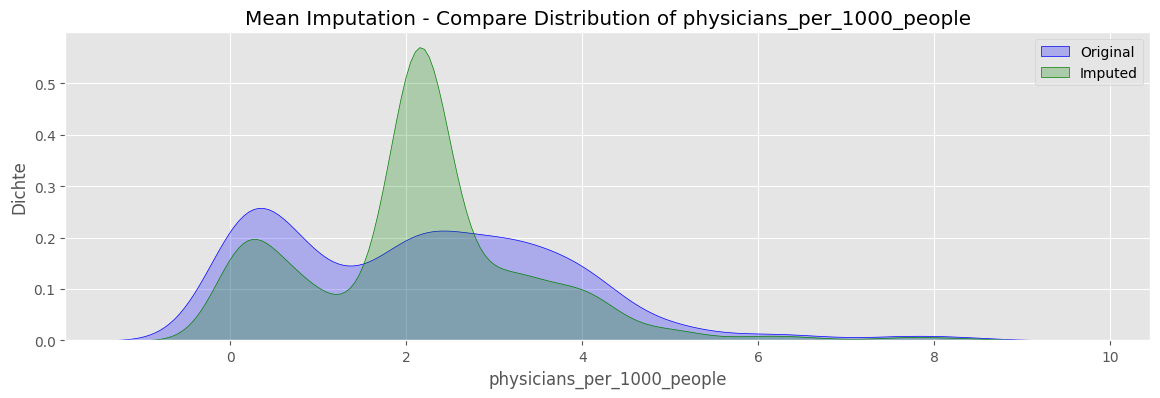

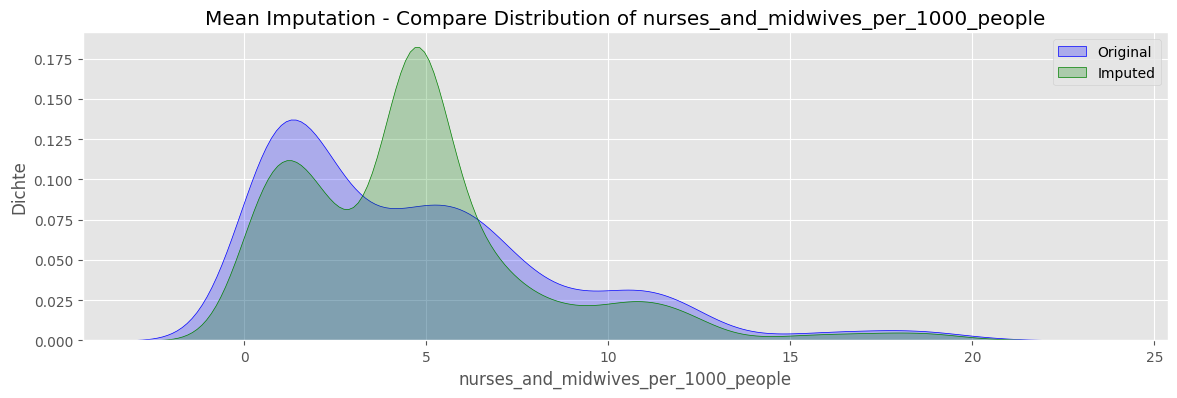

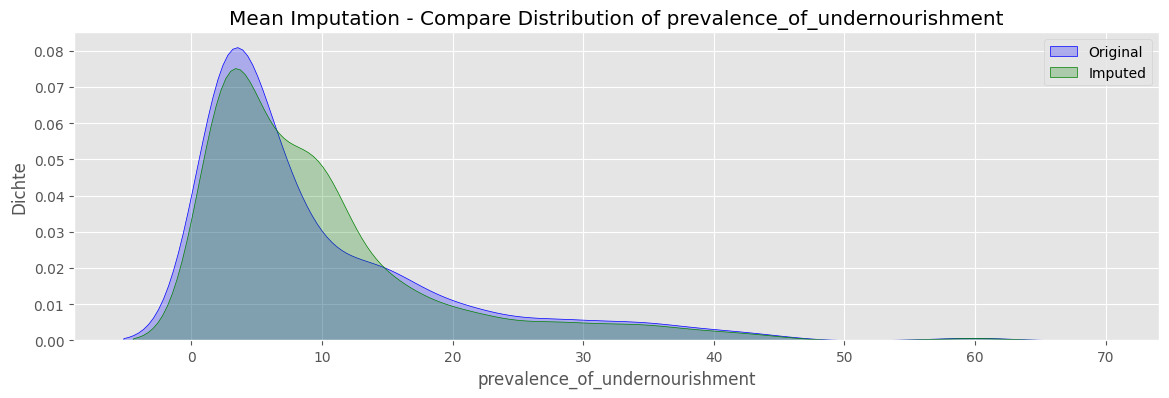

In [15]:
# KDE Plots - Compare Original Variable Distribution & Imputed Variable Distribution
def kde_plot_comparison(original_df, imputed_df, variable, imp_type):
    plt.figure(figsize=(14,4))
    sns.kdeplot(original_df.loc[~original_df[variable].isna(), variable], color='blue', fill=True)
    sns.kdeplot(imputed_df[variable], color='green', fill=True)
    #plt.axvline(x=original_df[variable].mean(), color='red', linestyle='-')
    plt.title(f"{imp_type} - Compare Distribution of {variable}")
    plt.ylabel('Dichte')
    plt.legend(["Original", "Imputed"])
    plt.show()

# Plot for the 3 variables with most nans
kde_plot_comparison(df_imp_test, mean_df, "physicians_per_1000_people", "Mean Imputation")
kde_plot_comparison(df_imp_test, mean_df, "nurses_and_midwives_per_1000_people", "Mean Imputation")
kde_plot_comparison(df_imp_test, mean_df, "prevalence_of_undernourishment", "Mean Imputation")

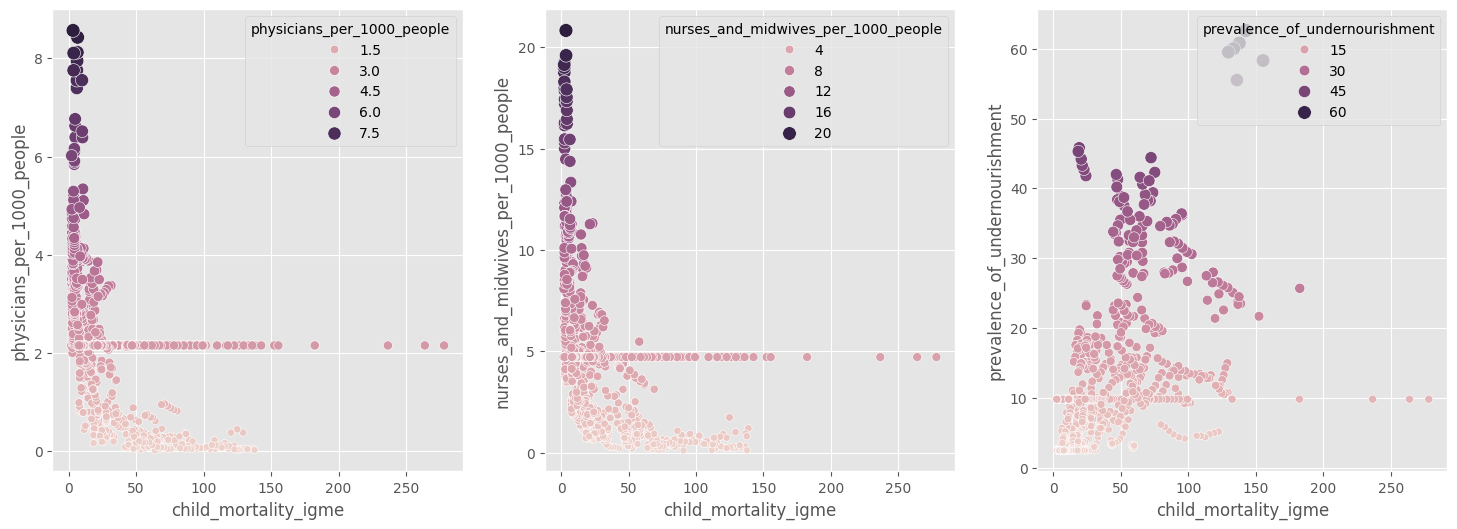

In [16]:
data_exploration.scatterplots(mean_df, most_critical_cols, 3)

##### Median

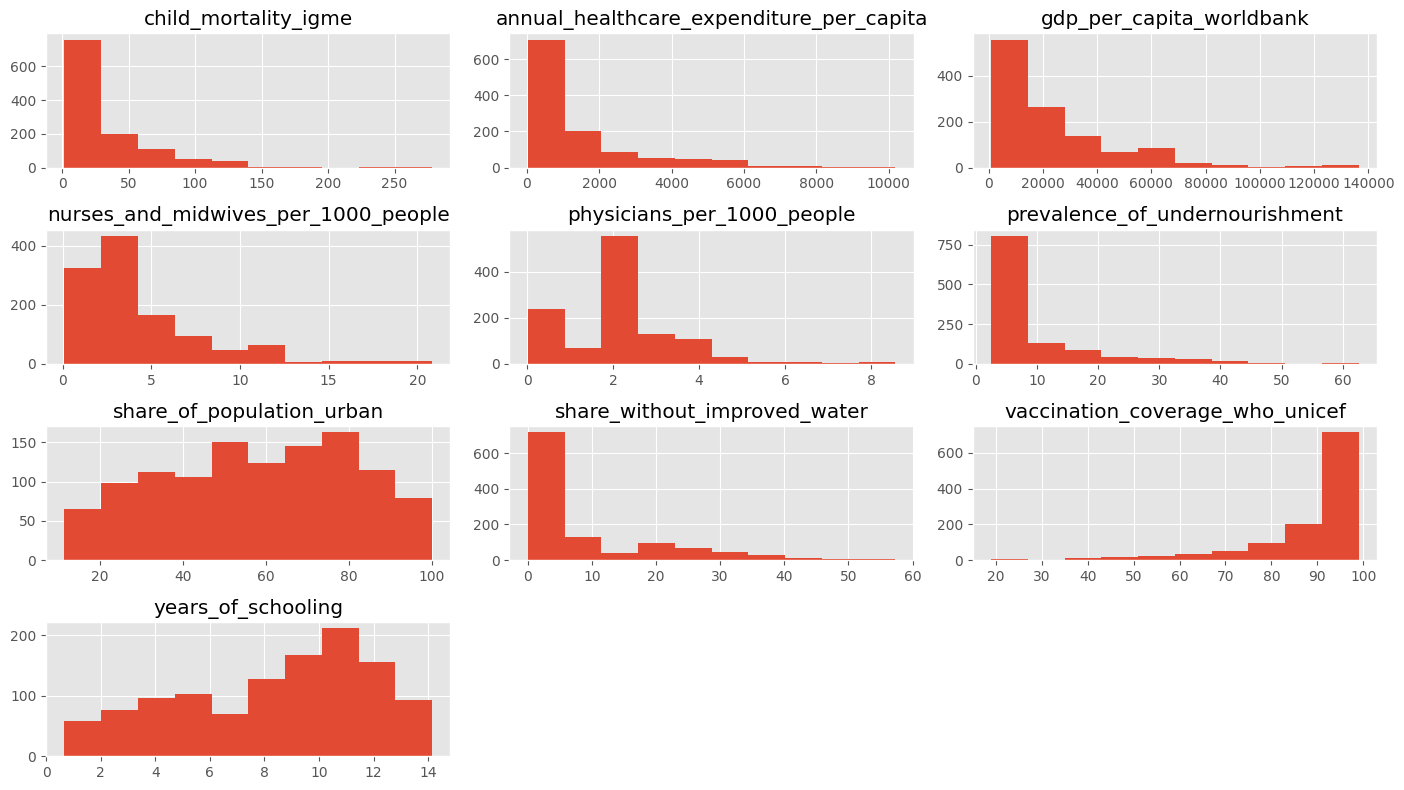

Variance Differences in %:
annual_healthcare_expenditure_per_capita    -1.16
gdp_per_capita_worldbank                    -3.20
nurses_and_midwives_per_1000_people        -25.08
physicians_per_1000_people                 -35.00
prevalence_of_undernourishment             -11.71
share_without_improved_water                -1.06
vaccination_coverage_who_unicef             -0.45
years_of_schooling                          -2.17
dtype: float64


In [17]:
imputed_with_median = df_imp_test.copy()
imputed_with_median = imputed_with_median.fillna(imputed_with_median.median())
median_df = imputed_with_median.loc[:, ~nan_indicators(imputed_with_median) & ~wb_regions(imputed_with_median)]

median_df = pd.concat([label_col, median_df], axis=1)

#show histograms
data_exploration.histograms(median_df)
calculate_metrics(df_imp_test, median_df, cols_with_nans)

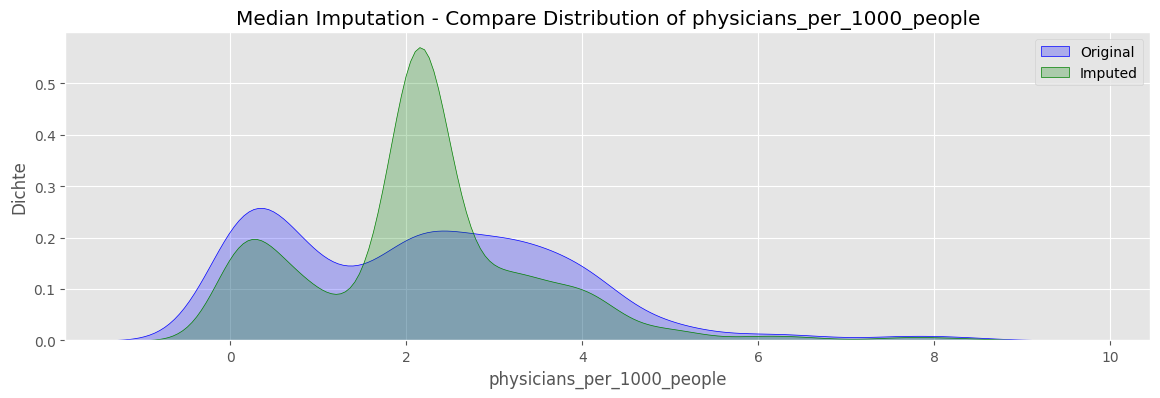

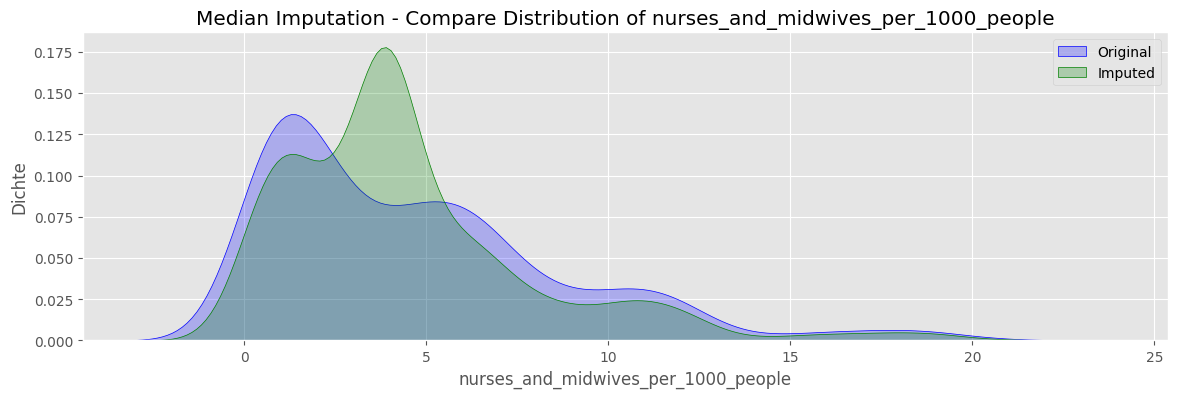

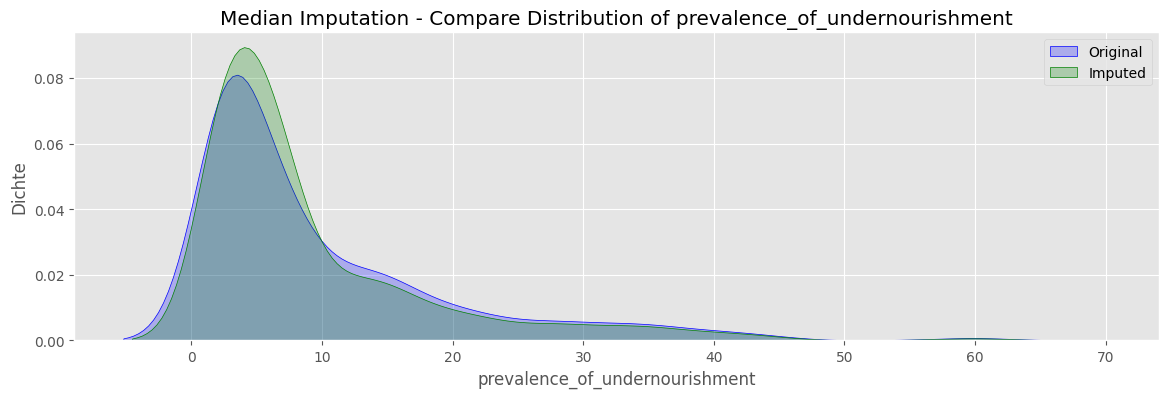

In [18]:
# KDE Plots for the 3 variables with most nans
kde_plot_comparison(df_imp_test, median_df, "physicians_per_1000_people", "Median Imputation")
kde_plot_comparison(df_imp_test, median_df, "nurses_and_midwives_per_1000_people", "Median Imputation")
kde_plot_comparison(df_imp_test, median_df, "prevalence_of_undernourishment", "Median Imputation")

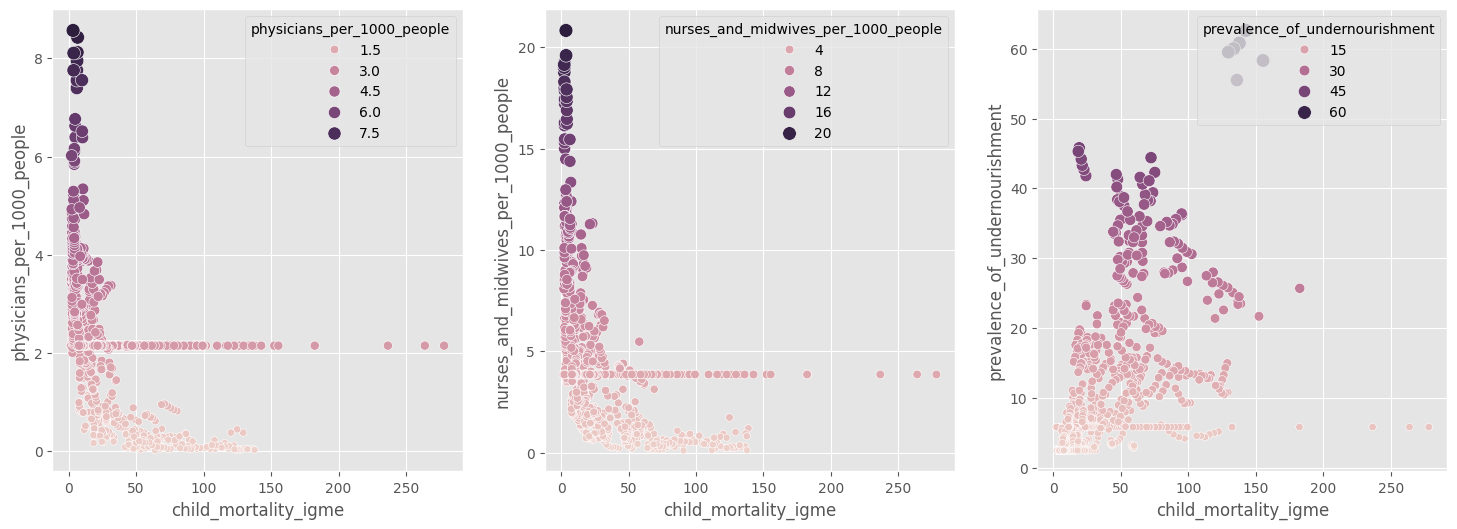

In [19]:
data_exploration.scatterplots(median_df, most_critical_cols, 3)

#### Test 2 - Median but country- & region-specific

##### Median Grouped by country or region

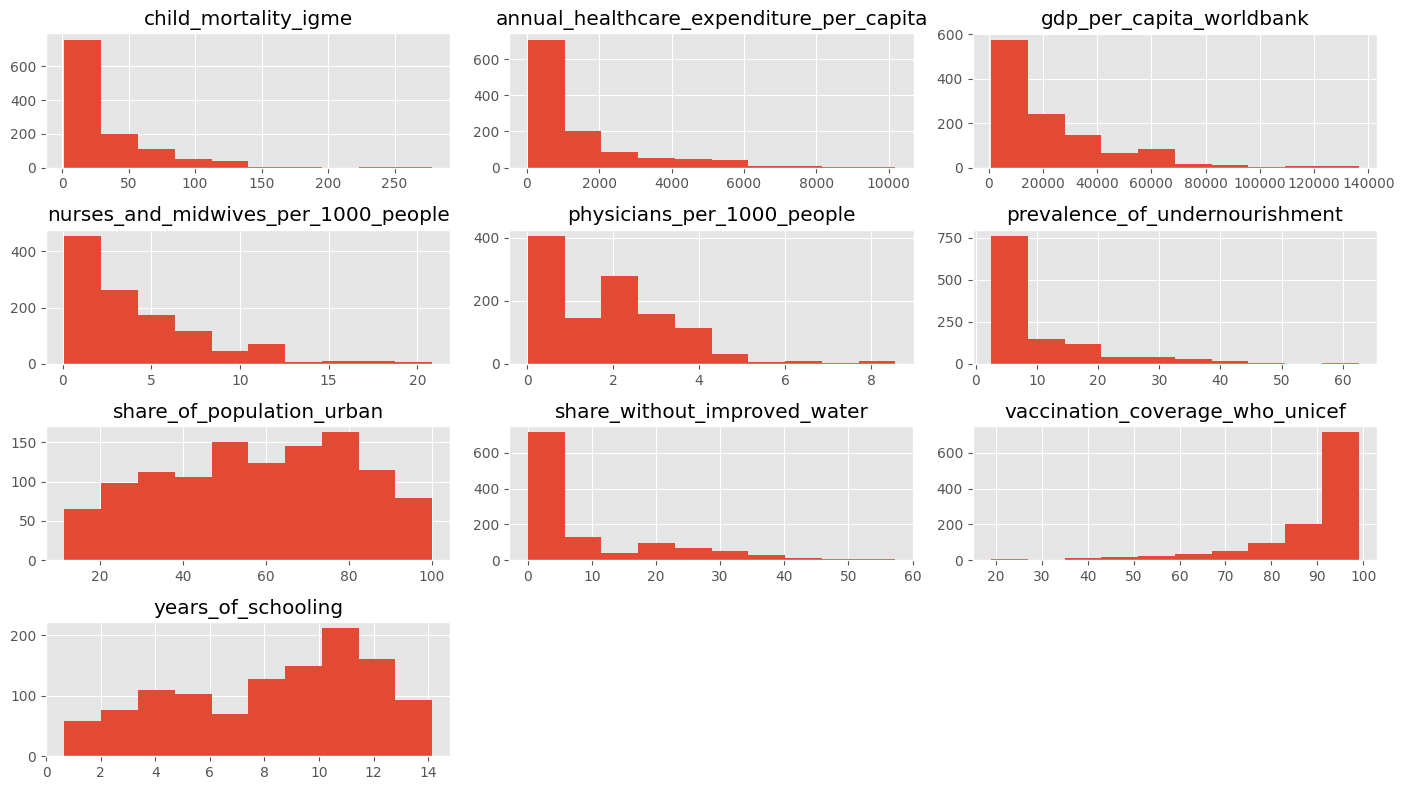

Variance Differences in %:
annual_healthcare_expenditure_per_capita    -0.98
gdp_per_capita_worldbank                    -2.51
nurses_and_midwives_per_1000_people        -13.35
physicians_per_1000_people                 -12.62
prevalence_of_undernourishment             -10.80
share_without_improved_water                 0.07
vaccination_coverage_who_unicef             -0.48
years_of_schooling                          -0.42
dtype: float64


In [20]:
def groupbased_median_imputation(df):

    imputed_groupwise = df.copy()
    numeric_cols = imputed_groupwise.select_dtypes(include=["float64"]).columns.tolist()
    #rows_per_country = imputed_groupwise.groupby("Entity").size().iloc[0]

    for numeric_col in numeric_cols:
        if imputed_groupwise[numeric_col].isna().sum() > 0:
            nans_by_country = imputed_groupwise.groupby("Entity")[numeric_col].transform(lambda x: x.isna().sum())

            # for less nans per Entity in a col, use median by Entity, otherwise median of WorldBank region 
            country_median = imputed_groupwise.groupby("Entity")[numeric_col].transform("median")
            region_median = imputed_groupwise.groupby("World regions according to WB")[numeric_col].transform("median")
            global_median = imputed_groupwise[numeric_col].median()
            
            imputes = np.where(nans_by_country <= 3, country_median, region_median)
            imputes = np.where(np.isnan(imputes), global_median, imputes)

            imp_types = pd.Series(imputes, index=imputed_groupwise.index)
            imputed_groupwise[numeric_col] = imputed_groupwise[numeric_col].fillna(imp_types)
    return imputed_groupwise
        
group_median_df = groupbased_median_imputation(df_imp_test_full)

group_median_df = group_median_df.loc[:, ~nan_indicators(group_median_df) & ~wb_regions(group_median_df)]
#show histograms
data_exploration.histograms(group_median_df.drop(columns=["Year"]))

#calculate metrics
calculate_metrics(df_imp_test, group_median_df, cols_with_nans)

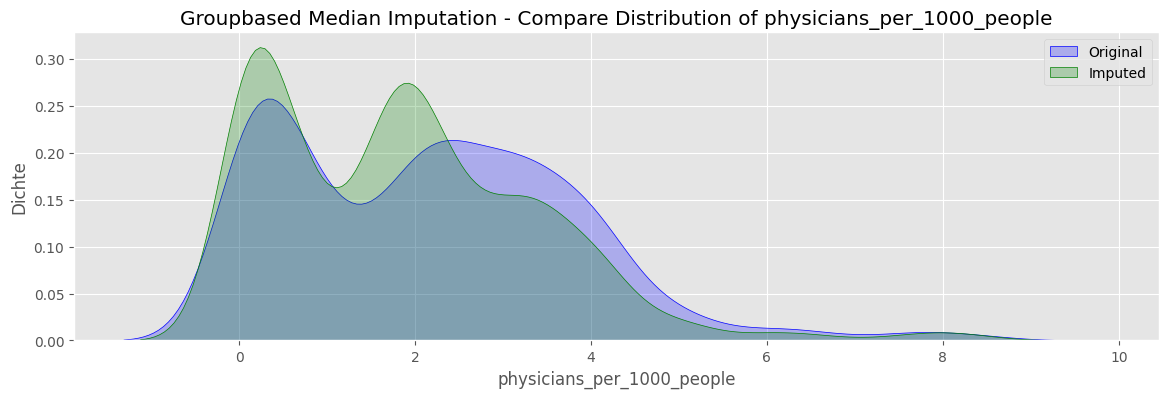

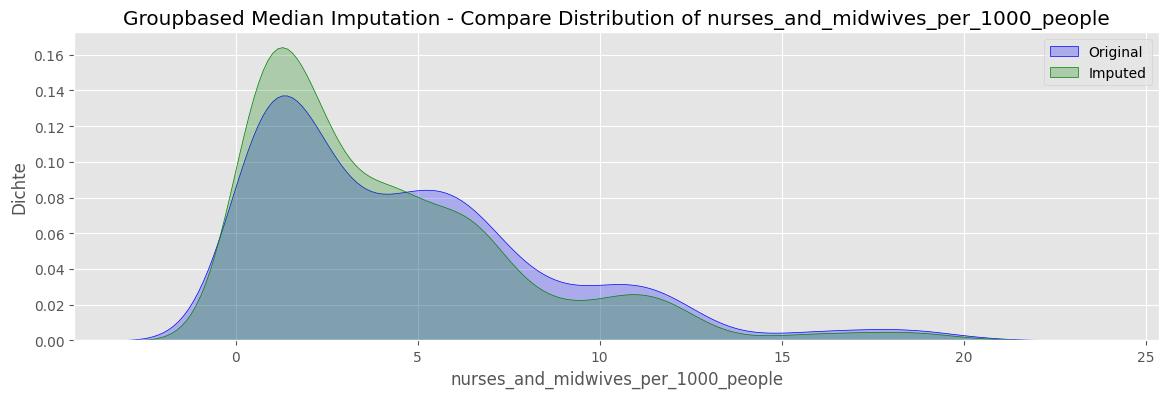

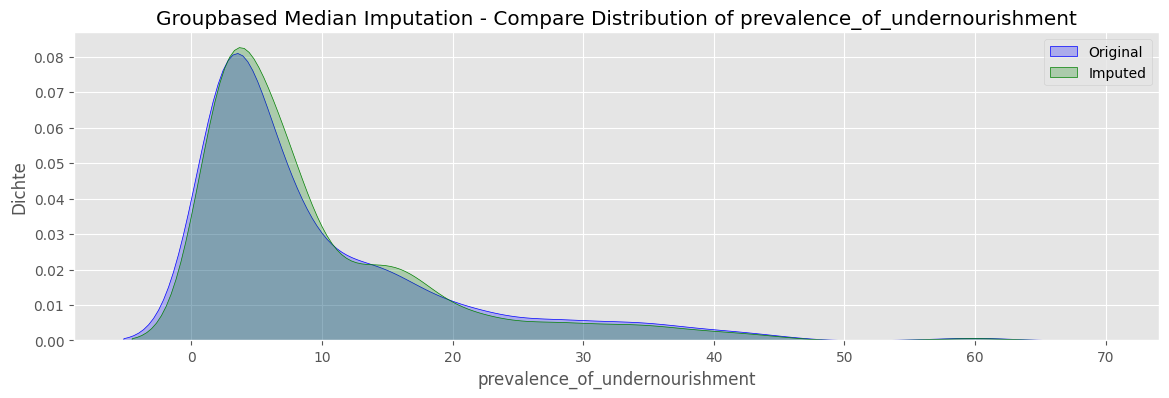

In [21]:
kde_plot_comparison(df_imp_test, group_median_df, "physicians_per_1000_people", "Groupbased Median Imputation")
kde_plot_comparison(df_imp_test, group_median_df, "nurses_and_midwives_per_1000_people", "Groupbased Median Imputation")
kde_plot_comparison(df_imp_test, group_median_df, "prevalence_of_undernourishment", "Groupbased Median Imputation")

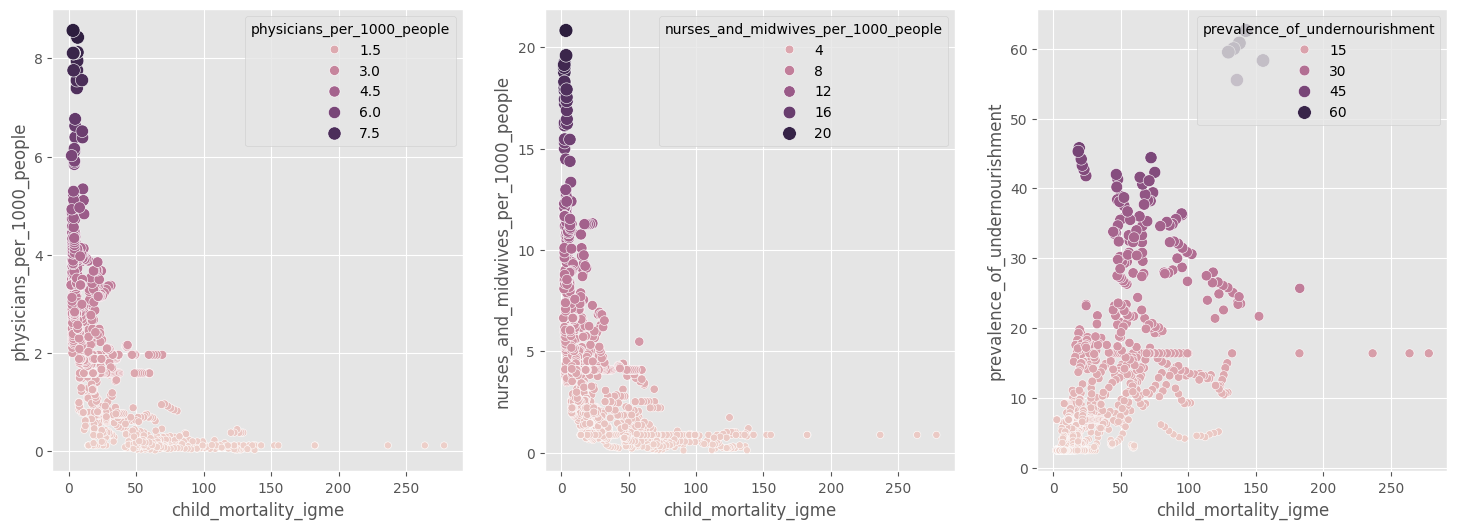

In [22]:
data_exploration.scatterplots(group_median_df, most_critical_cols, 3)

In [23]:
#save temporary groupbased median imputed df 
group_median_df.to_csv("../00_data/1_interim/group_median_imputed.csv", index=False)

#### Test3 - KNN Imputer

In [24]:
# Impute with KNN - scale data before (with RobustScaler) for distancebased knn imputer
from sklearn.preprocessing import RobustScaler 
from sklearn.impute import KNNImputer

def knn_imputation(df):
    imputed_with_knn = df.copy()
    imputed_with_knn = imputed_with_knn.loc[:, ~nan_indicators(imputed_with_knn) & ~wb_regions(imputed_with_knn)]
    
    rscaler = RobustScaler().fit(imputed_with_knn)
    rscaled_data = rscaler.transform(imputed_with_knn)

    imputer = KNNImputer(n_neighbors=5, weights="distance") #as base use k=5
    knn_imputed_scaled = imputer.fit_transform(rscaled_data)
    # reverse back to original value ranges
    knn_imputed = rscaler.inverse_transform(knn_imputed_scaled)

    df_knn_imputed = pd.DataFrame(knn_imputed, columns=imputed_with_knn.columns, index=imputed_with_knn.index)

    return df_knn_imputed

knn_df = knn_imputation(df_imp_test)
knn_df = knn_df.loc[:, ~nan_indicators(knn_df) & ~wb_regions(knn_df)]
knn_df = pd.concat([label_col, knn_df], axis=1) #add label to df

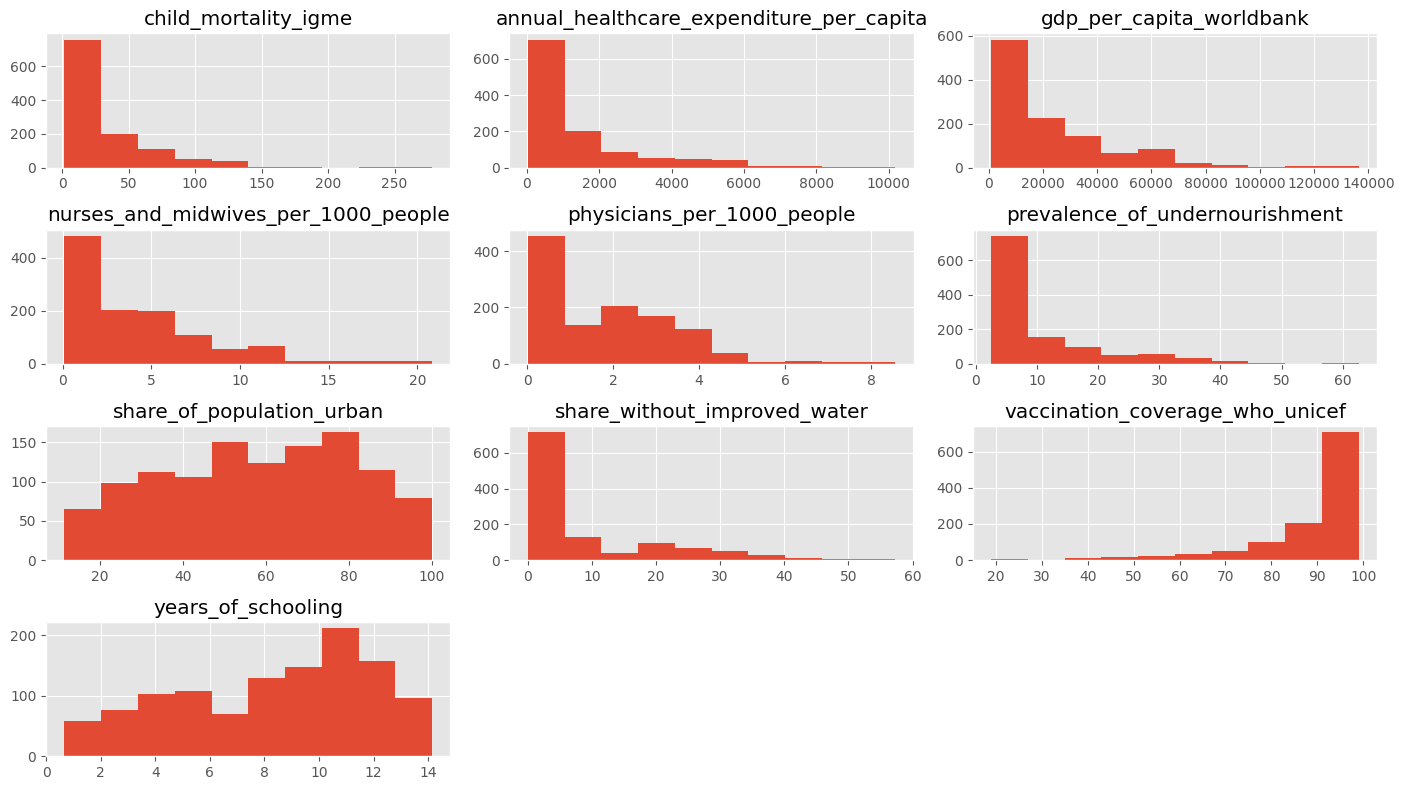

Variance Differences in %:
annual_healthcare_expenditure_per_capita   -1.00
gdp_per_capita_worldbank                    1.46
nurses_and_midwives_per_1000_people        -6.19
physicians_per_1000_people                 -7.71
prevalence_of_undernourishment             -1.11
share_without_improved_water               -0.07
vaccination_coverage_who_unicef            -0.51
years_of_schooling                          0.04
dtype: float64


In [25]:
#show histograms
data_exploration.histograms(knn_df)

#calculate metrics
calculate_metrics(df_imp_test, knn_df, cols_with_nans)

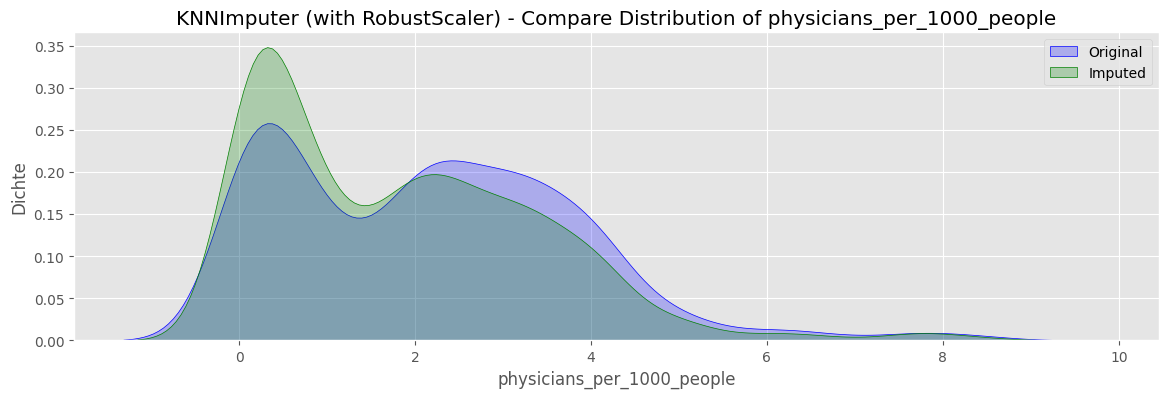

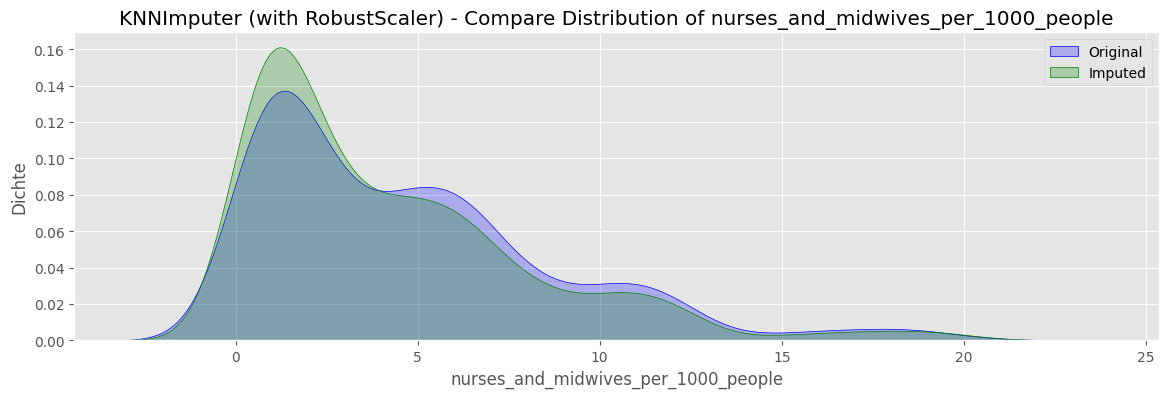

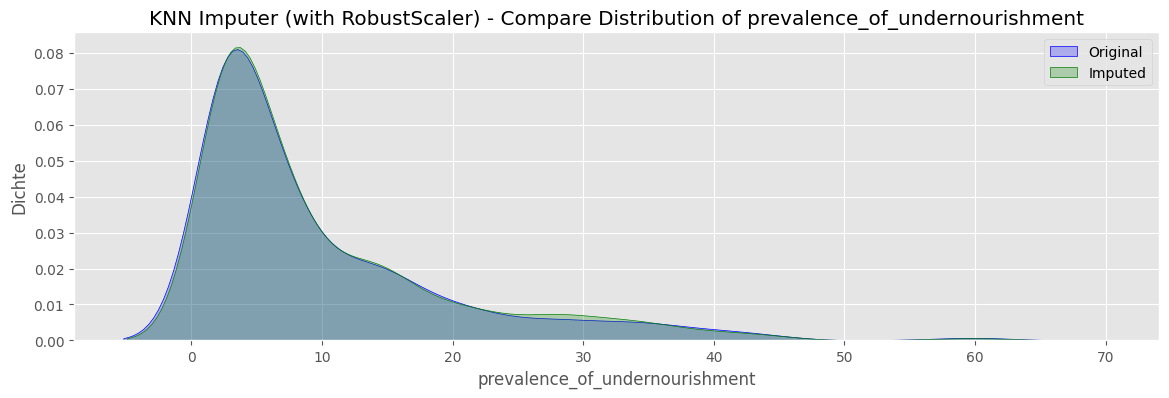

In [26]:
kde_plot_comparison(df_imp_test, knn_df, "physicians_per_1000_people", "KNNImputer (with RobustScaler)")
kde_plot_comparison(df_imp_test, knn_df, "nurses_and_midwives_per_1000_people", "KNNImputer (with RobustScaler)")
kde_plot_comparison(df_imp_test, knn_df, "prevalence_of_undernourishment", "KNN Imputer (with RobustScaler)")

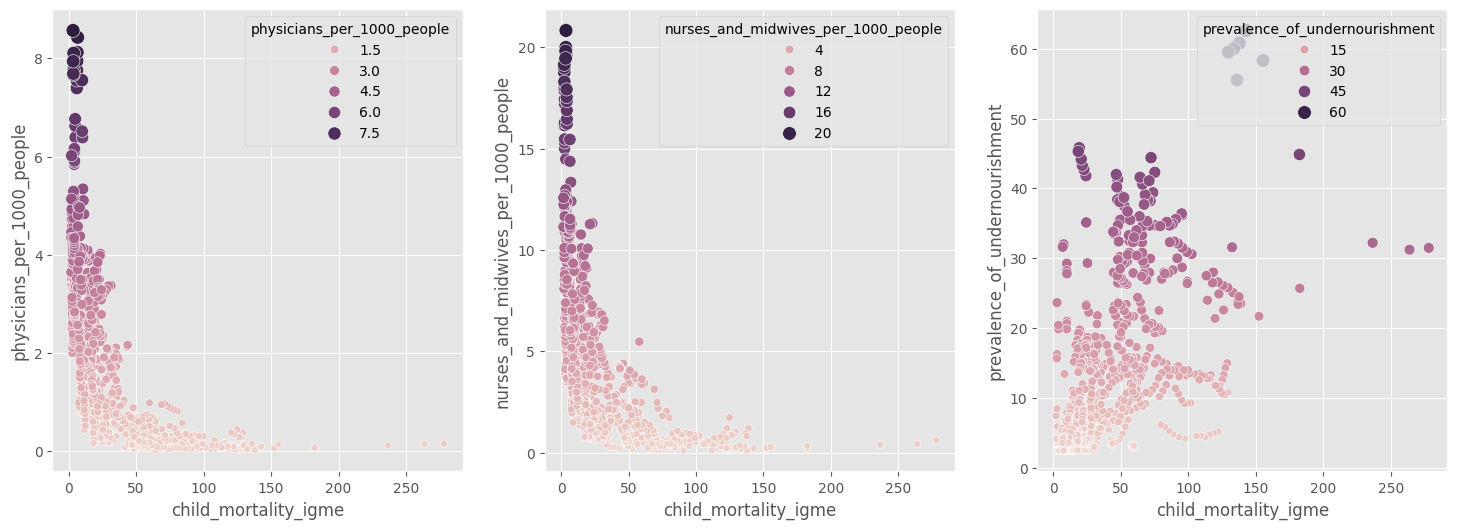

In [27]:
data_exploration.scatterplots(knn_df, most_critical_cols, 3)

In [39]:
#save temporary knnimputed df for more EDA
knn_df.to_csv("../00_data/1_interim/knnimputed.csv", index=False)

In [40]:
knnimputed_df = knn_df.copy()
knnimputed_df[["Code", "Entity", "Year"]] = filtered_df[["Code", "Entity", "Year"]].values

In [42]:
knnimputed_df.to_csv("../00_data/1_interim/knnimputed_full.csv", index=False)

In [25]:
#from sklearn.model_selection import GroupShuffleSplit

#gss = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
#for id_train, id_test in gss.split(df_imp_test, groups=df_imp_test["Code"]):
#    train_df = df_imp_test.iloc[id_train]
#    test_df = df_imp_test.iloc[id_test]
#train_df = train_df.drop(columns=["Code"])

#### Test with IterativeImputer

In [134]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

def iter_impute(df):
    imputed_with_iterativeimp = df.copy()
    imputed_with_iterativeimp = imputed_with_iterativeimp.loc[:, ~nan_indicators(imputed_with_iterativeimp) 
                                                              & ~wb_regions(imputed_with_iterativeimp)]

    rscaler2 = RobustScaler().fit(imputed_with_iterativeimp)
    rscaled_data2 = rscaler2.transform(imputed_with_iterativeimp)

    rf_estim = ExtraTreesRegressor(n_estimators=10, min_samples_leaf=10, n_jobs=-1, random_state=99)

    single_imputer = IterativeImputer(
        estimator=rf_estim,
        max_iter=80,  
        random_state=99,
        initial_strategy='median' 
    )
    iterativeimp_scaled = single_imputer.fit_transform(rscaled_data2)
    # reverse back to original value ranges
    iterativeimp_imputed = rscaler2.inverse_transform(iterativeimp_scaled)

    df_imputed = pd.DataFrame(iterativeimp_imputed, columns=imputed_with_iterativeimp.columns, index=imputed_with_iterativeimp.index)
    return df_imputed

ii_df = iter_impute(df_imp_test)

ii_df = ii_df.loc[:, ~nan_indicators(ii_df) & ~wb_regions(ii_df)]
#removed_cols = df_for_imp[["Code", "Year", "Entity", "child_mortality_igme"]]
ii_df = pd.concat([label_col, ii_df], axis=1) #add label to df

/Users/hamzahfayad/myportfolio/master_thesis_child_mortality/masterthesis_venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


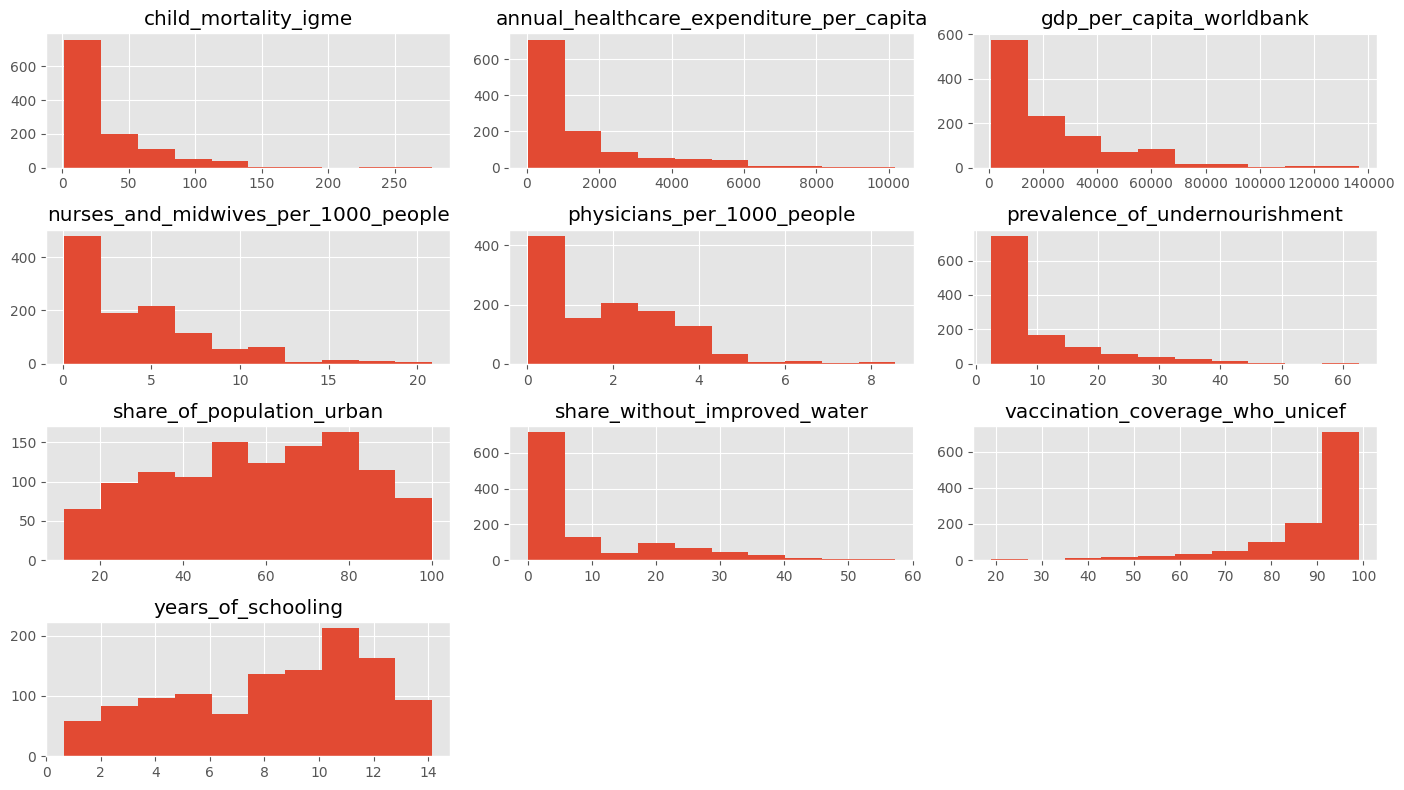

Variance Differences in %:
annual_healthcare_expenditure_per_capita    -1.06
gdp_per_capita_worldbank                     1.81
nurses_and_midwives_per_1000_people        -10.20
physicians_per_1000_people                 -12.68
prevalence_of_undernourishment              -7.59
share_without_improved_water                -0.48
vaccination_coverage_who_unicef             -0.51
years_of_schooling                           0.03
dtype: float64


In [135]:
#show histograms
data_exploration.histograms(ii_df)

#calculate metrics
calculate_metrics(df_imp_test, ii_df, cols_with_nans)

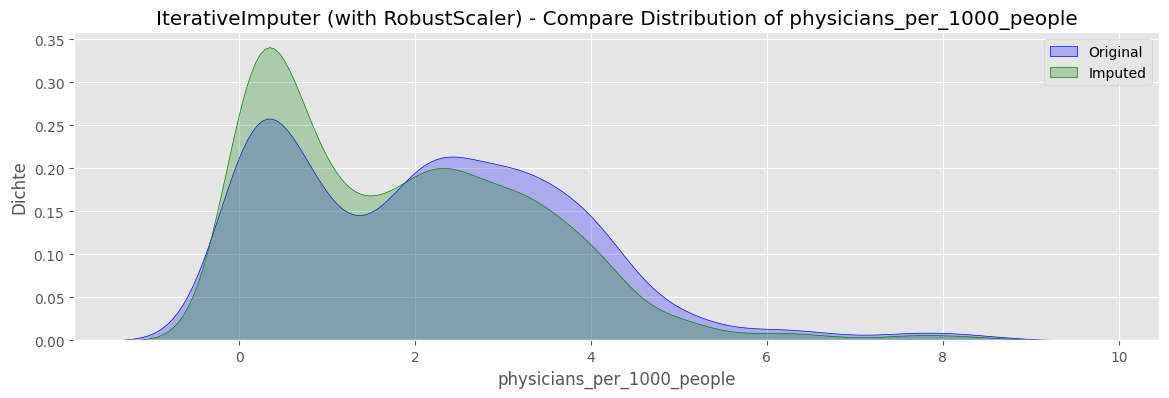

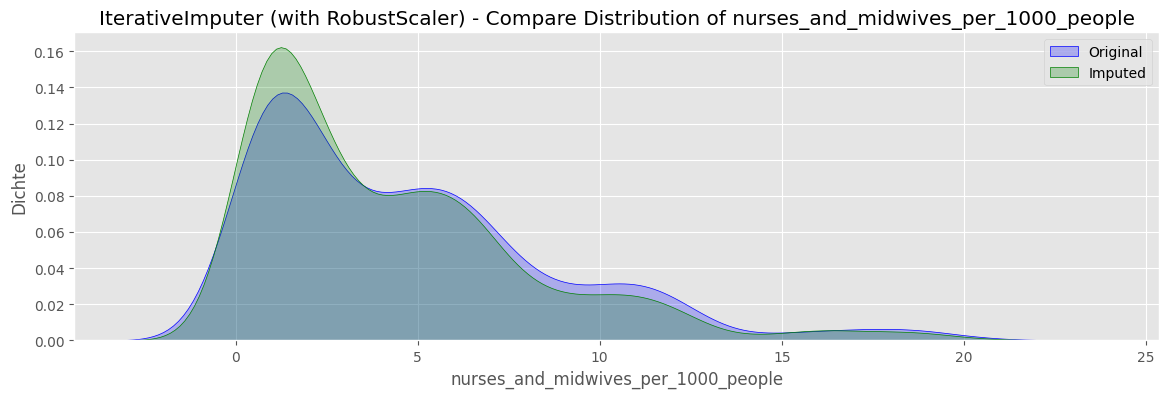

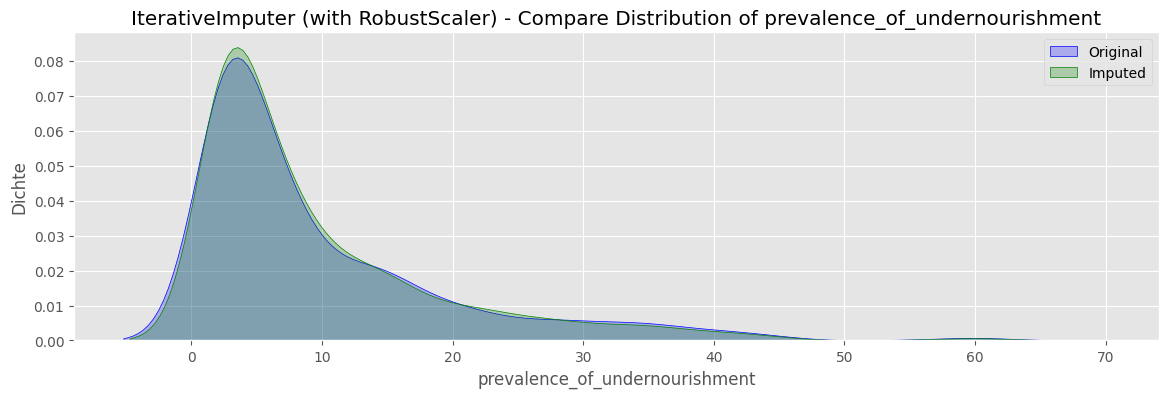

In [136]:
kde_plot_comparison(df_imp_test, ii_df, "physicians_per_1000_people", "IterativeImputer (with RobustScaler)")
kde_plot_comparison(df_imp_test, ii_df, "nurses_and_midwives_per_1000_people", "IterativeImputer (with RobustScaler)")
kde_plot_comparison(df_imp_test, ii_df, "prevalence_of_undernourishment", "IterativeImputer (with RobustScaler)")

### Explorative Cluster

In [163]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
# use knn imputed
country = df_for_imp["Entity"]
knn_df["Entity"] = country
# aggregate - each country one row (use mean e.g.)
knn_df_agg = knn_df.groupby("Entity").agg("mean")
knn_df_agg = knn_df_agg.drop(columns=["child_mortality_igme"])
# use log transfrom
knn_df_agg_log = knn_df_agg.apply(lambda k: np.log1p(k))
# scale
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(knn_df_agg_log)

tsne = TSNE(n_components=2, perplexity=15, learning_rate="auto", random_state=99)
df_dim = tsne.fit_transform(df_scaled)

In [164]:
from sklearn.cluster import KMeans
# 6 clusters >> based on EDA Erkenntnisse
kmeans = KMeans(n_clusters=6, random_state=99)
clusters = kmeans.fit_predict(df_dim)

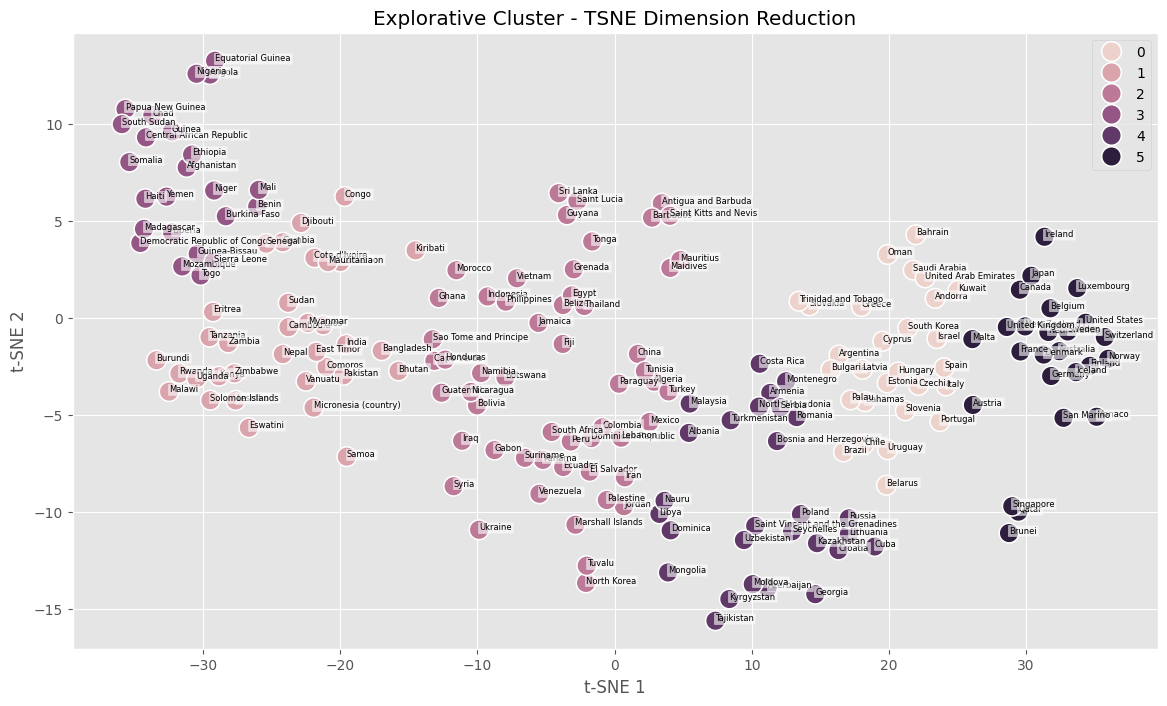

In [165]:
# Visualize Scatterplot, cluster labels without hierarchy order
df_tsne = pd.DataFrame(data=df_dim, columns=['t-SNE 1', 't-SNE 2'])

plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='t-SNE 1',
    y='t-SNE 2',
    s=200,
    hue=clusters,
    data=df_tsne,
)

for i, c in enumerate(knn_df_agg.index):
    plt.text(df_dim[i, 0], df_dim[i, 1], c, fontsize=6, bbox=dict(facecolor='white', alpha=0.6, pad=0.8))

plt.title("Explorative Cluster - TSNE Dimension Reduction")
#plt.xlim(-30, 30)
plt.show()

In [166]:
##### tsne_dimensions = df_tsne.copy()
aggregated_df = knn_df_agg.copy()
aggregated_df = aggregated_df.reset_index()

tsne_dimensions["Entity"] = aggregated_df["Entity"]

### Simulate Missingness for quantitative evaluation

In [167]:
sim_df = df_imp_test.copy()
# part of df that is 100% complete (627 rows)
sim_df_complete = sim_df.dropna(how="any")
# part of df that has all nans (531 rows)
sim_df_nans = sim_df[sim_df.isna().any(axis=1)]

In [168]:
# add missingness into sim_df_complete df (same % from sim_df_nans for each column to simulate missingness)
sim_df_temp = sim_df_complete.copy()
nans_perc = round((sim_df_nans.isna().sum() / len(sim_df_nans)) * 100, 2)

np.random.seed(99) #always same randoms

for idc, col in enumerate(sim_df_temp.columns):
    nan_perc = nans_perc.iloc[idc]
    random_nans = np.random.choice(sim_df_temp.index, replace=False, size=int( len(sim_df_temp) * (nan_perc/100) ))
    #add nans into df for each column based on nan percentage value from sim_df_nans
    sim_df_temp.loc[random_nans, col] = np.nan

    

for col in df_for_imp.columns[df_for_imp.isna().any()].tolist():
    mask = sim_df_temp[col].isna()
    complete_mask = sim_df_complete.loc[mask, col]
#sim_df_temp now has missing values to simulate & evaluate imputation techniques

#### Use imputation methods on sim_df_temp & compare 

In [169]:
# 1) Mean Imputation
sim_df_imp_mean = sim_df_temp.copy()
sim_df_imp_mean = sim_df_imp_mean.fillna(sim_df_imp_mean.mean())

In [170]:
# 2) Median Imputation
sim_df_imp_median = sim_df_temp.copy()
sim_df_imp_median = sim_df_imp_median.fillna(sim_df_imp_median.median())

In [171]:
# 3) Groupbased Median Imputation
sim_df_group_median = sim_df_temp.copy()
sim_df_group_median["Entity"] = df_imp_test_full.loc[sim_df_group_median.index, "Entity"]
sim_df_group_median["World regions according to WB"] = df_imp_test_full.loc[sim_df_group_median.index, "World regions according to WB"]

#sim_df_groups_median = sim_df_full_temp.copy()
sim_df_group_median = groupbased_median_imputation(sim_df_group_median)

In [172]:
# 4) KNN Imputer
sim_df_knn_imp = sim_df_temp.copy()
sim_df_knn_imp = knn_imputation(sim_df_knn_imp)

In [173]:
# 5) IterativeImputer
sim_df_iter_imp = sim_df_temp.copy()
sim_df_iter_imp = iter_impute(sim_df_iter_imp)

/Users/hamzahfayad/myportfolio/master_thesis_child_mortality/masterthesis_venv/lib/python3.11/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [174]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def compare_metrics(df_imputed, imp_method):
    pd.set_option('display.float_format', '{:.2f}'.format)
    print(f"{imp_method}\n")
    metrics_results = []
    
    for col in df_for_imp.columns[df_for_imp.isna().any()].tolist():
        nans_mask = sim_df_temp[col].isna()
        y_compl = sim_df_complete.loc[nans_mask, col] 
        y_imp = df_imputed.loc[nans_mask, col]

        mae = mean_absolute_error(y_compl, y_imp)
        rmse = np.sqrt(mean_squared_error(y_compl, y_imp))
        r2 = r2_score(y_compl, y_imp)

        #print(f"{col}: MAE: {mae:.2f}, RMSE: {rmse:.2f}")

        df_res = pd.DataFrame({"Variable": [col], "MAE": [mae], "RMSE": [rmse], "R2": [r2]})
        metrics_results.append(df_res)
        
    final_res = pd.concat(metrics_results).reset_index(drop=True)
    return final_res

In [175]:
compare_metrics(sim_df_imp_mean, "simple Mean Imputation")

simple Mean Imputation



,Variable,MAE,RMSE,R2
0,annual_healthcare_expenditure_per_capita,1255.79,1403.79,-0.18
1,gdp_per_capita_worldbank,20182.85,22903.21,-0.02
2,nurses_and_midwives_per_1000_people,3.38,4.35,-0.00
3,physicians_per_1000_people,1.29,1.53,-0.00
4,prevalence_of_undernourishment,5.34,7.17,-0.01
5,share_without_improved_water,8.76,12.40,-0.05
6,vaccination_coverage_who_unicef,6.11,6.71,-4.74
7,years_of_schooling,2.73,3.36,-0.00


In [176]:
compare_metrics(sim_df_imp_median, "simple Median Imputation")

simple Median Imputation



,Variable,MAE,RMSE,R2
0,annual_healthcare_expenditure_per_capita,974.72,1297.75,-0.01
1,gdp_per_capita_worldbank,18610.35,23013.33,-0.03
2,nurses_and_midwives_per_1000_people,3.37,4.46,-0.06
3,physicians_per_1000_people,1.29,1.54,-0.01
4,prevalence_of_undernourishment,4.43,7.93,-0.24
5,share_without_improved_water,8.87,14.49,-0.44
6,vaccination_coverage_who_unicef,3.29,3.53,-0.59
7,years_of_schooling,2.74,3.57,-0.13


In [177]:
compare_metrics(sim_df_group_median, "Groupbased Median Imputation")

Groupbased Median Imputation



,Variable,MAE,RMSE,R2
0,annual_healthcare_expenditure_per_capita,110.28,160.85,0.98
1,gdp_per_capita_worldbank,1321.47,2699.87,0.99
2,nurses_and_midwives_per_1000_people,1.89,3.25,0.44
3,physicians_per_1000_people,0.81,1.13,0.45
4,prevalence_of_undernourishment,1.07,2.82,0.84
5,share_without_improved_water,2.33,7.20,0.65
6,vaccination_coverage_who_unicef,1.50,2.34,0.30
7,years_of_schooling,0.40,0.80,0.94


In [178]:
compare_metrics(sim_df_knn_imp, "KNNImputer")

KNNImputer



,Variable,MAE,RMSE,R2
0,annual_healthcare_expenditure_per_capita,90.53,142.18,0.99
1,gdp_per_capita_worldbank,2410.81,4206.07,0.97
2,nurses_and_midwives_per_1000_people,0.98,1.60,0.86
3,physicians_per_1000_people,0.43,0.61,0.84
4,prevalence_of_undernourishment,1.99,4.37,0.62
5,share_without_improved_water,3.13,5.41,0.80
6,vaccination_coverage_who_unicef,2.93,4.76,-1.89
7,years_of_schooling,0.56,0.82,0.94


In [179]:
compare_metrics(sim_df_iter_imp, "IterativeImputer")

IterativeImputer



,Variable,MAE,RMSE,R2
0,annual_healthcare_expenditure_per_capita,176.53,277.42,0.95
1,gdp_per_capita_worldbank,3365.99,4899.35,0.95
2,nurses_and_midwives_per_1000_people,1.34,1.97,0.79
3,physicians_per_1000_people,0.53,0.75,0.76
4,prevalence_of_undernourishment,2.63,4.55,0.59
5,share_without_improved_water,4.57,6.58,0.70
6,vaccination_coverage_who_unicef,5.14,6.76,-4.83
7,years_of_schooling,0.92,1.11,0.89
